# Train and test statistical n-gram models



In [1]:
!pip install nltk==3.4 transformers

     |████████████████████████████████| 1.4MB 32.2MB/s 
     |████████████████████████████████| 2.1MB 29.5MB/s 
     |████████████████████████████████| 3.3MB 32.7MB/s 
     |████████████████████████████████| 901kB 30.6MB/s 
  Created wheel for nltk: filename=nltk-3.4-cp37-none-any.whl size=1436385 sha256=c6cd73928dcb050062ad617bc6cc323d8d14e33301fe955a7ef6f5f0f0f230ce
  Stored in directory: /root/.cache/pip/wheels/4b/c8/24/b2343664bcceb7147efeb21c0b23703a05b23fcfeaceaa2a1e
Successfully built nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


## Load tokenizer

In [2]:
!gdown https://drive.google.com/uc?id=1-2g-GCxjBwESqDn3JByAJABU9Dkuqy0m

Downloading...
From: https://drive.google.com/uc?id=1-2g-GCxjBwESqDn3JByAJABU9Dkuqy0m
To: /content/childes_all_new.json
100% 332k/332k [00:00<00:00, 5.16MB/s]


In [3]:
TOKENIZER_PATH = "./childes_all_new.json" # you can change this path to use your custom tokenizer

from transformers import PreTrainedTokenizerFast

loaded_tokenizer = PreTrainedTokenizerFast(tokenizer_file=TOKENIZER_PATH)
loaded_tokenizer.pad_token = "[PAD]"
loaded_tokenizer.sep_token = "[SEP]"
loaded_tokenizer.mask_token = "[MASK]"
loaded_tokenizer.cls_token = "[CLS]"
loaded_tokenizer.unk_token = "[UNK]"

## Loading datasets

In [4]:
!gdown https://drive.google.com/uc?id=1Mn2eIeSCBLk8tpU2NwNQblooFcqSbjmh
!gdown https://drive.google.com/uc?id=1qEX2zVxX8xFbBfY4mLSf0qG4wgkHFggD
!gdown https://drive.google.com/uc?id=1BwPXeP3lKQk-orKAq1bs2C7hg-B1D6QG

Downloading...
From: https://drive.google.com/uc?id=1Mn2eIeSCBLk8tpU2NwNQblooFcqSbjmh
To: /content/train_childes_all.pt
247MB [00:03, 68.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1qEX2zVxX8xFbBfY4mLSf0qG4wgkHFggD
To: /content/test_childes_all.pt
2.52MB [00:00, 39.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BwPXeP3lKQk-orKAq1bs2C7hg-B1D6QG
To: /content/val_childes_all.pt
2.52MB [00:00, 39.1MB/s]


In [5]:
import pickle

train_dataset = pickle.load(open('./train_childes_all.pt','rb'))

val_dataset = pickle.load(open('./val_childes_all.pt','rb'))

test_dataset = pickle.load(open('./test_childes_all.pt','rb'))

In [6]:
train = [loaded_tokenizer.convert_ids_to_tokens(s) for s in train_dataset['ngrams'] + val_dataset['ngrams']]
test = [loaded_tokenizer.convert_ids_to_tokens(s) for s in test_dataset['ngrams']]

## NLTK MLE

We used NLTK MLE due to the low memory consumption.


In [8]:
from nltk.lm import Vocabulary
from nltk.lm.preprocessing import flatten

all = list(flatten(train+test)) # combine datasets
vocab = Vocabulary(all)         # get vocab

In [7]:
from nltk import ngrams
from nltk.lm import MLE
import numpy as np
import math

## Train and test

In [9]:
import pandas as pd

ppl_df = pd.DataFrame(columns=["n",'Cross Entropy','Perplexity'])

In [10]:
max_order = 5
entropies = []
ppls = []
for order in range(2,max_order+1):
  train_data = [list(ngrams(sentence,order,pad_left=True,left_pad_symbol="[PAD]")) for sentence in train]
  test_data = [list(ngrams(sentence,order,pad_left=True,left_pad_symbol="[PAD]")) for sentence in test]

  lm = MLE(order,vocabulary=vocab)

  lm.fit(train_data)

  all_scores = [lm.logscore(a[-1],a[:-1]) if lm.logscore(a[-1],a[:-1]) != -math.inf else 0.0 for a in flatten(test_data)]
  entropy = -1 * np.mean(all_scores)
  entropies.append(entropy)
  ppls.append(math.exp(entropy))
  print("Order:", order)
  print("Cross Entropy:", entropy)
  print("Perplexity:", math.exp(entropy))
  print()

Order: 2
Cross Entropy: 5.3993701887905425
Perplexity: 221.26701586397223

Order: 3
Cross Entropy: 3.7820436023897113
Perplexity: 43.90567586023316

Order: 4
Cross Entropy: 3.043260441072137
Perplexity: 20.973514785963815

Order: 5
Cross Entropy: 2.805126389084704
Perplexity: 16.529164880068233



In [11]:
ppl_df['order'] = list(range(2,max_order+1))
ppl_df['Cross Entropy'] = entropies
ppl_df['Perplexity'] = ppls

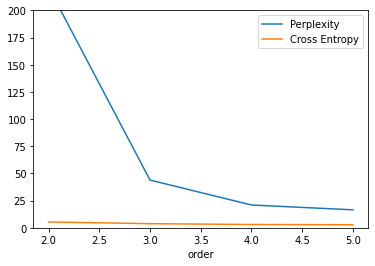

In [12]:
ppl_df.plot(x="order",y=['Perplexity',"Cross Entropy"],ylim=(0,200))